In [10]:
# Import necessary modules
from PyLCM.animation import *
from PyLCM.widget import *
from PyLCM.timestep_routine import *
from PyLCM.parameters import *
# Import user modifiable modules
from Post_process.analysis import *
from Post_process.print_plot import *

# Uncomment lines below when changing source files
#######################
%load_ext autoreload
%autoreload 2
#######################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Initialisation

In [11]:
from IPython.display import clear_output

dt_widget, nt_widget, Condensation_widget, Collision_widget, switch_sedi_removal, n_particles_widget, max_z_widget = model_steering_input()
T_widget, P_widget, RH_widget, w_widget, z_widget = parcel_info_input()
ascending_mode_widget = ascending_mode_input()
entrainment_widget, stability_widget, entrainment_start_widget, entrainment_end_widget, entrainment_rate_widget  = entrainment_input()
kohler_widget = kohler_settings()
hygroscopicity_widget = kappa_settings()
mode_aero_init_widget = aero_mode_input()
gridwidget = grid_modes_input()
mode_displaytype_widget = timestep_display_mode_settings()


# You can override the widget values by entering the inputs in the code below
# This is more convenient as the widgets override your original input when reloaded

# Model steering parameters

dt_widget.value = 1 # s
nt_widget.value = 3000
Condensation_widget.value = True
Collision_widget.value = True
switch_sedi_removal.value = False
n_particles_widget.value = 1000
max_z_widget.value = 3000 # m


# Parcel initial parameters

T_widget.value = 289.27 # K
P_widget.value = 101181 # Pa
RH_widget.value = 0.83
w_widget.value = 0.3 # m s-1
z_widget.value = 0 # m
ascending_mode_widget.value = 'linear' # linear / sine / in_cloud_oscillation


# Entrainment parameters

entrainment_widget.value = False
stability_widget.value = 'Stable' # Stable / Unstable / Neutral
entrainment_start_widget.value = 1000 # s
entrainment_end_widget.value = 1030 # s
entrainment_rate_widget.value = 0.05 # ?

qv_init = RH_widget.value * esatw( T_widget.value ) / ( P_widget.value - RH_widget.value * esatw( T_widget.value ) ) * r_a / rv
qv_profiles, theta_profiles, z_env = create_env_profiles(T_widget.value, qv_init, z_widget.value, P_widget.value, stability_widget.value)


# Koehler theory

kohler_widget.value = False
hygroscopicity_widget.value = False
mode_aero_init_widget.value = 'Random' # Random / Weighting_factor


# Initialisation parameters for aerosol (up to 4 modes)
# mu = mean droplet radius | sigma = std. of mu | kappa = hygroscopicity parameter

# # Mode #1
# gridwidget[1,0].value = 11.7 # N_aero (cm-3)
# gridwidget[2,0].value = 9.0e-6 # mu (um)
# gridwidget[3,0].value = 1.416 # sigma (-)
# gridwidget[4,0].value = 1.6 # kappa

# # Mode #2
# gridwidget[1,1].value = 38.4 # N_aero (cm-3)
# gridwidget[2,1].value = 19.5e-6 # mu (um)
# gridwidget[3,1].value = 1.425 # sigma (-)
# gridwidget[4,1].value = 1.6 # kappa

# # Mode #3
# gridwidget[1,2].value = 41.7 # N_aero (cm-3)
# gridwidget[2,2].value = 77.0e-6 # mu (um)
# gridwidget[3,2].value = 1.592 # sigma (-)
# gridwidget[4,2].value = 1.6 # kappa

# # Mode #4
# gridwidget[1,3].value = 0 # N_aero (cm-3)
# gridwidget[2,3].value = 0 # mu (um)
# gridwidget[3,3].value = 0 # sigma (-)
# gridwidget[4,3].value = 0 # kappa


# Display mode

mode_displaytype_widget.value = 'text_fast' # text_fast / graphics


# Comment this out the display the widgets
clear_output()

# Run model

In [12]:
nt, dt, time_array, T_parcel_array, P_parcel_array, RH_parcel_array, q_parcel_array, z_parcel_array, \
qa_ts, qc_ts, qr_ts, na_ts, nc_ts, nr_ts, \
spectra_arr, con_ts, act_ts, evp_ts, dea_ts, acc_ts, aut_ts, precip_ts, particles_array, \
rc_liq_avg_array, rc_liq_std_array, TAU_ts_array, albedo_array \
= timesteps_function(
    n_particles_widget, P_widget, \
    RH_widget, T_widget, w_widget, nt_widget, \
    dt_widget, rm_spec, ascending_mode_widget, \
    mode_displaytype_widget, z_widget, max_z_widget, \
    Condensation_widget, Collision_widget, \
    mode_aero_init_widget, gridwidget, kohler_widget.value, \
    hygroscopicity_widget.value, switch_sedi_removal.value, \
    entrainment_rate_widget.value,entrainment_widget.value,qv_profiles, theta_profiles, entrainment_start_widget.value, entrainment_end_widget.value
)

value: Time (s)  z (m)    T (K)    qv (g/kg) RH (%)   QC (g/kg) QR (g/kg) NA (/mg) NC (/mg) NR (/mg)
after: 3000.0    900.00   283.05   8.47      100.077   0.900     0.129     62.48     31.07     1.36    


# Analysis

In [13]:
from PyLCM.parcel import parcel_rho

In [14]:
z_parcel_array_adj = z_parcel_array - 400

rho_parcel_array, _, _ = parcel_rho(P_parcel_array, T_parcel_array)

# qc_ts in units of g/kg
lwp_array = np.cumsum(rho_parcel_array * qc_ts)
rwp_array = np.cumsum(rho_parcel_array * qr_ts)

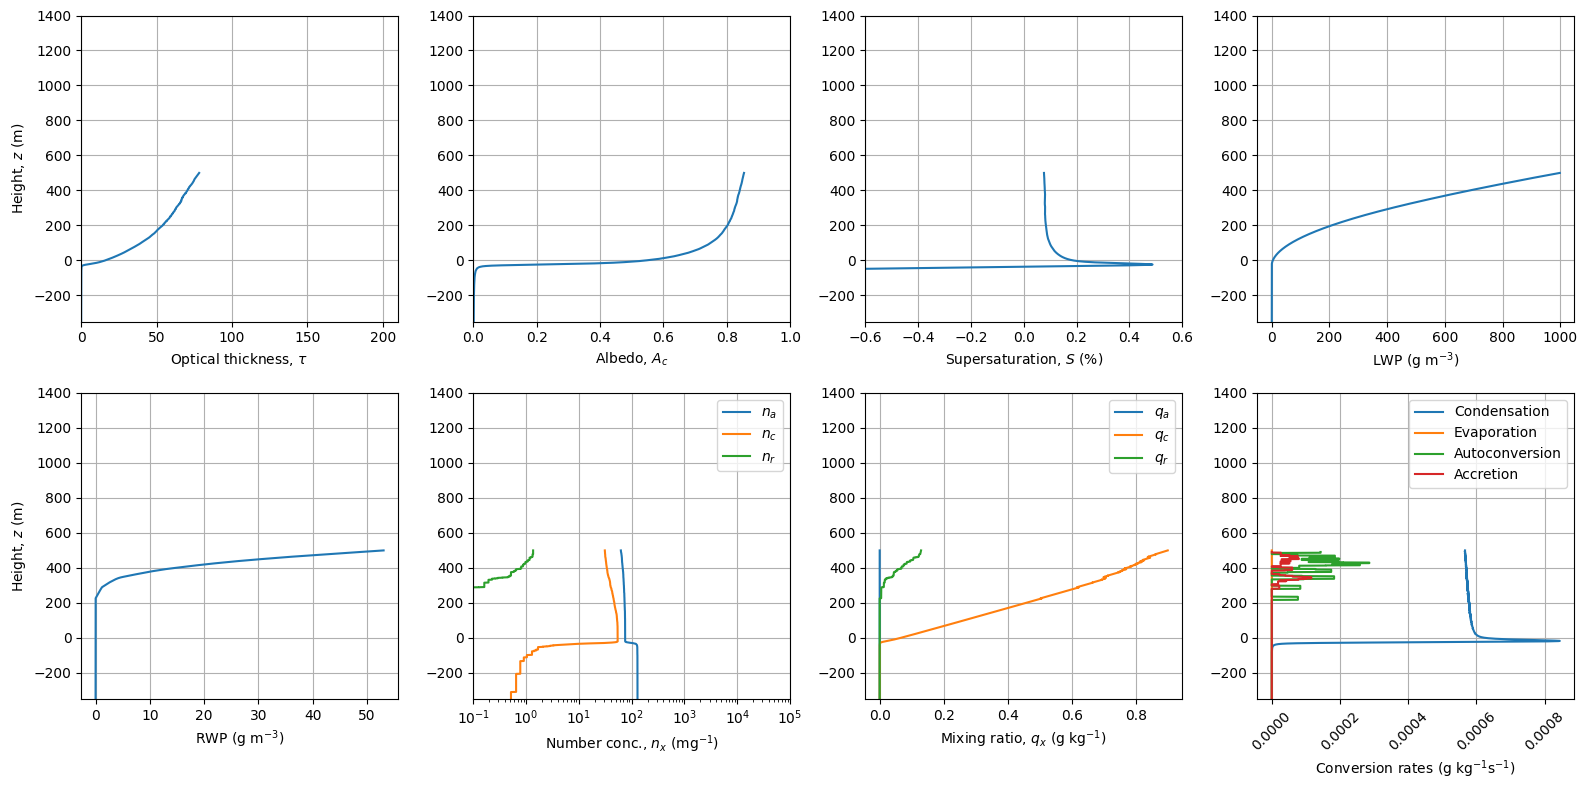

In [15]:
fig, ax = plt.subplots(2, 4, figsize=(16,8))

ax0 = ax[0,0]; ax1 = ax[0,1]; ax2 = ax[0,2]; ax3 = ax[0,3]
ax4 = ax[1,0]; ax5 = ax[1,1]; ax6 = ax[1,2]; ax7 = ax[1,3]

ax0.plot(TAU_ts_array, z_parcel_array_adj)
ax1.plot(albedo_array, z_parcel_array_adj)
ax2.plot((RH_parcel_array-1)*100, z_parcel_array_adj)
ax3.plot(lwp_array, z_parcel_array_adj)
ax4.plot(rwp_array, z_parcel_array_adj)
ax5.plot(na_ts, z_parcel_array_adj, label='$n_a$'); ax5.plot(nc_ts, z_parcel_array_adj, label='$n_c$'); ax5.plot(nr_ts, z_parcel_array_adj, label='$n_r$')
ax6.plot(qa_ts, z_parcel_array_adj, label='$q_a$'); ax6.plot(qc_ts, z_parcel_array_adj, label='$q_c$'); ax6.plot(qr_ts, z_parcel_array_adj, label='$q_r$')

ax7.plot(con_ts, z_parcel_array_adj, label='Condensation')
ax7.plot(evp_ts, z_parcel_array_adj, label='Evaporation')

window_length = 60
aut_ts_rolling = pd.Series(aut_ts).rolling(window=window_length).mean().iloc[window_length-1:].values
acc_ts_rolling = pd.Series(acc_ts).rolling(window=window_length).mean().iloc[window_length-1:].values
z_parcel_rolling = pd.Series(z_parcel_array_adj).rolling(window=window_length).mean().iloc[window_length-1:].values

ax7.plot(aut_ts_rolling, z_parcel_rolling, label='Autoconversion')
ax7.plot(acc_ts_rolling, z_parcel_rolling, label='Accretion')


ax0.set_ylabel('Height, $z$ (m)')
ax4.set_ylabel('Height, $z$ (m)')

ax0.set_xlabel('Optical thickness, $τ$')
ax1.set_xlabel('Albedo, $A_c$')
ax2.set_xlabel('Supersaturation, $S$ (%)')
ax3.set_xlabel('LWP (g m$^{-3}$)')
ax4.set_xlabel('RWP (g m$^{-3}$)')
ax5.set_xlabel('Number conc., $n_x$ (mg$^{-1}$)')
ax6.set_xlabel('Mixing ratio, $q_x$ (g kg$^{-1}$)')
ax7.set_xlabel('Conversion rates (g kg$^{-1}$s$^{-1}$)')

ax0.grid(); ax1.grid(); ax2.grid(); ax3.grid()
ax4.grid(); ax5.grid(); ax6.grid(); ax7.grid()

ylim = [50-400, 1400]
ax0.set_ylim(ylim); ax1.set_ylim(ylim); ax2.set_ylim(ylim); ax3.set_ylim(ylim)
ax4.set_ylim(ylim); ax5.set_ylim(ylim); ax6.set_ylim(ylim); ax7.set_ylim(ylim)

ax0.set_xlim(0,210)
ax1.set_xlim(0,1)
ax2.set_xlim(-0.6,0.6)
# ax3.set_xlim(0,1000)
# ax4.set_xlim(0,1000)
ax5.set_xlim(1e-1,1e5)

ax5.set_xscale('log')
ax7.tick_params(axis='x', labelrotation=45)

ax5.legend()
ax6.legend()
ax7.legend()


plt.tight_layout()
plt.show()